# Pipe Inspection Robot - AI-Powered Defect Detection

This notebook implements neural network models for pipe defect detection using computer vision techniques.

## Project Overview
- **Custom CNN + FFN Architecture**: A custom convolutional neural network with fully connected layers
- **MobileNetV3 Baseline**: Pre-trained MobileNetV3 model for comparison
- **Data Augmentation**: Comprehensive augmentation techniques to improve accuracy
- **Binary Classification**: Class1 (Normal) vs Class2 (Defective) pipe images

## Dataset Structure
```
data/
├── train/
│   ├── class1/     # Normal pipe images
│   └── class2/     # Defective pipe images
├── validation/
│   ├── class1/
│   └── class2/
└── test/
    ├── class1/
    └── class2/
```


In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torchvision.transforms as T
from PIL import Image
import os
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Data paths
train_dir = '/root/phd/css706/hw1/data/train'
val_dir = '/root/phd/css706/hw1/data/validation'
test_dir = '/root/phd/css706/hw1/data/test'

print("Libraries imported successfully!")


Using device: cpu
Libraries imported successfully!


## 1. Dataset Exploration

Let's first explore the dataset to understand its structure and characteristics.


In [4]:
# Explore dataset structure
def explore_dataset():
    """Explore the dataset structure and visualize sample images"""
    
    data_dirs = {
        'train': train_dir,
        'validation': val_dir,
        'test': test_dir
    }
    
    print("Dataset Statistics:")
    print("=" * 50)
    
    total_images = 0
    for split, data_dir in data_dirs.items():
        print(f"\n{split.upper()} SET:")
        for class_name in ['class1', 'class2']:
            class_dir = os.path.join(data_dir, class_name)
            if os.path.exists(class_dir):
                image_count = len([f for f in os.listdir(class_dir) if f.endswith('.jpg')])
                print(f"  {class_name}: {image_count} images")
                total_images += image_count
            else:
                print(f"  {class_name}: Directory not found")
    
    print(f"\nTotal images: {total_images}")
    return total_images

# Run dataset exploration
total_images = explore_dataset()


Dataset Statistics:

TRAIN SET:
  class1: 2106 images
  class2: 2106 images

VALIDATION SET:
  class1: 185 images
  class2: 185 images

TEST SET:
  class1: 257 images
  class2: 256 images

Total images: 5095


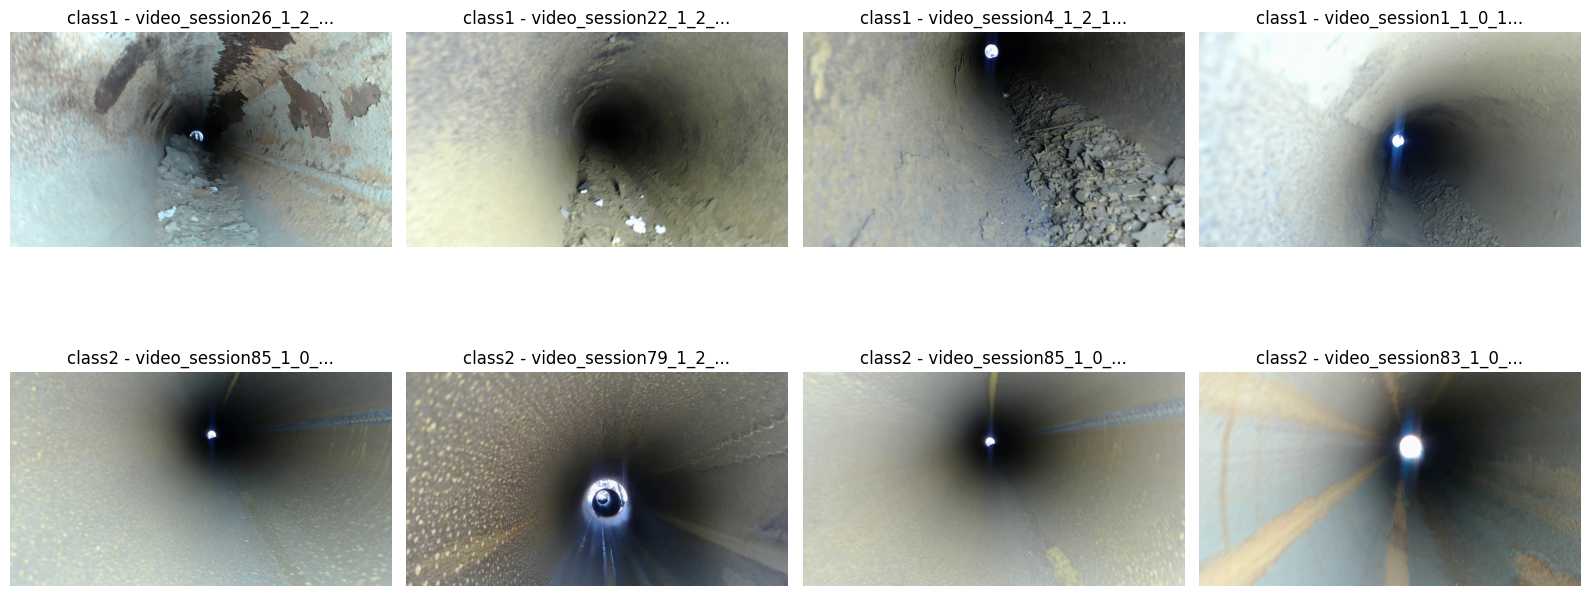

In [5]:
# Visualize sample images from the dataset
def visualize_samples():
    """Visualize sample images from each class"""
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    # Sample images from each class
    for i, class_name in enumerate(['class1', 'class2']):
        class_dir = os.path.join(train_dir, class_name)
        if os.path.exists(class_dir):
            image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
            
            # Show 4 sample images from each class
            for j in range(4):
                if j < len(image_files):
                    img_path = os.path.join(class_dir, image_files[j])
                    img = Image.open(img_path)
                    
                    axes[i*4 + j].imshow(img)
                    axes[i*4 + j].set_title(f'{class_name} - {image_files[j][:20]}...')
                    axes[i*4 + j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample images
visualize_samples()


## 2. Custom Dataset Class

Create a custom dataset class to handle the pipe inspection images.


In [6]:
class PipeInspectionDataset(Dataset):
    """Custom dataset for pipe inspection images"""
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Load images and labels
        for class_name in ['class1', 'class2']:
            class_dir = os.path.join(data_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith('.jpg'):
                        self.images.append(os.path.join(class_dir, img_name))
                        self.labels.append(0 if class_name == 'class1' else 1)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("Custom dataset class created successfully!")


Custom dataset class created successfully!


## 3. Data Augmentation and Transforms

Implement comprehensive data augmentation techniques to improve model performance.


In [7]:
def get_data_transforms():
    """Get data augmentation transforms"""
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

# Get transforms
train_transform, val_transform = get_data_transforms()

# Create datasets
train_dataset = PipeInspectionDataset(train_dir, transform=train_transform)
val_dataset = PipeInspectionDataset(val_dir, transform=val_transform)
test_dataset = PipeInspectionDataset(test_dir, transform=val_transform)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Data loaders created successfully!")


Training samples: 4212
Validation samples: 370
Test samples: 513
Data loaders created successfully!


## 4. Custom CNN + FFN Architecture

Implement a custom convolutional neural network with fully connected layers for pipe defect detection.


In [8]:
class CustomCNN(nn.Module):
    """Custom CNN + FFN architecture for pipe defect detection"""
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(2, 2)
        
        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers (FFN)
        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.relu6 = nn.ReLU()
        
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.relu7 = nn.ReLU()
        
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # Convolutional layers
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        x = self.pool5(self.relu5(self.bn5(self.conv5(x))))
        
        # Global average pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout1(self.relu6(self.fc1(x)))
        x = self.dropout2(self.relu7(self.fc2(x)))
        x = self.fc3(x)
        
        return x

# Create and test the model
custom_cnn = CustomCNN(num_classes=2).to(device)
print(f'Custom CNN parameters: {sum(p.numel() for p in custom_cnn.parameters()):,}')

# Test with a sample input
sample_input = torch.randn(1, 3, 224, 224).to(device)
output = custom_cnn(sample_input)
print(f'Output shape: {output.shape}')
print("Custom CNN architecture created successfully!")


Custom CNN parameters: 1,735,042
Output shape: torch.Size([1, 2])
Custom CNN architecture created successfully!


## 5. MobileNetV3 Baseline Model

Implement MobileNetV3 as a baseline model for comparison with our custom CNN.


In [9]:
class MobileNetV3Baseline(nn.Module):
    """MobileNetV3 baseline model"""
    def __init__(self, num_classes=2, pretrained=True):
        super(MobileNetV3Baseline, self).__init__()
        self.backbone = models.mobilenet_v3_large(pretrained=pretrained)
        
        # Replace the classifier
        self.backbone.classifier = nn.Sequential(
            nn.Linear(self.backbone.classifier[0].in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# Create and test the model
mobilenet = MobileNetV3Baseline(num_classes=2, pretrained=True).to(device)
print(f'MobileNetV3 parameters: {sum(p.numel() for p in mobilenet.parameters()):,}')

# Test with a sample input
sample_input = torch.randn(1, 3, 224, 224).to(device)
output = mobilenet(sample_input)
print(f'Output shape: {output.shape}')
print("MobileNetV3 baseline model created successfully!")


MobileNetV3 parameters: 3,595,826
Output shape: torch.Size([1, 2])
MobileNetV3 baseline model created successfully!


## 6. Training Functions

Implement training and evaluation functions for both models.


In [10]:
def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001, device='cuda', model_name="Model"):
    """Train the model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    best_model_state = None
    
    print(f"\n{'='*60}")
    print(f"TRAINING {model_name.upper()}")
    print(f"{'='*60}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100 * train_correct / train_total:.2f}%'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100 * val_correct / val_total:.2f}%'
                })
        
        # Calculate average losses and accuracies
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Best Val Acc: {best_val_acc:.2f}%')
        print('-' * 50)
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

print("Training function created successfully!")


Training function created successfully!


In [11]:
def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate the model on test set"""
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, target_names=['Class1', 'Class2'])
    cm = confusion_matrix(all_labels, all_predictions)
    
    return accuracy, report, cm

def plot_training_history(history, model_name):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(history['train_losses'], label='Train Loss')
    ax1.plot(history['val_losses'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(history['train_accuracies'], label='Train Accuracy')
    ax2.plot(history['val_accuracies'], label='Validation Accuracy')
    ax2.set_title(f'{model_name} - Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, model_name):
    """Plot confusion matrix"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class1', 'Class2'], 
                yticklabels=['Class1', 'Class2'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

print("Evaluation and plotting functions created successfully!")


Evaluation and plotting functions created successfully!


## 7. Train Custom CNN Model

Now let's train our custom CNN model with data augmentation.


In [ ]:
# Train Custom CNN
custom_history = train_model(
    custom_cnn, 
    train_loader, 
    val_loader, 
    num_epochs=30,  # Reduced for notebook execution
    learning_rate=0.001, 
    device=device, 
    model_name="Custom CNN"
)



TRAINING CUSTOM CNN
Epoch 17/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:23<00:00,  1.96s/it, Loss=0.8994, Acc=79.19%]


Epoch 1/30 [Train]:   0%|                                                    | 0/132 [00:00<?, ?it/s]

Epoch 1/30 [Train]:  73%|█████████████▏    | 97/132 [06:04<02:24,  4.14s/it, Loss=0.4064, Acc=83.38%]

Epoch 17/30:
  Train Loss: 0.1087, Train Acc: 96.11%
  Val Loss: 0.5756, Val Acc: 79.19%
  Best Val Acc: 100.00%
--------------------------------------------------


Epoch 18/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:23<00:00,  1.99s/it, Loss=0.0005, Acc=99.73%]


Epoch 18/30:
  Train Loss: 0.1129, Train Acc: 96.18%
  Val Loss: 0.0113, Val Acc: 99.73%
  Best Val Acc: 100.00%
--------------------------------------------------


Epoch 19/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:30<00:00,  2.53s/it, Loss=0.0005, Acc=99.46%]


Epoch 19/30:
  Train Loss: 0.0975, Train Acc: 96.27%
  Val Loss: 0.0155, Val Acc: 99.46%
  Best Val Acc: 100.00%
--------------------------------------------------


Epoch 20/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:23<00:00,  1.94s/it, Loss=4.9446, Acc=58.65%]


Epoch 20/30:
  Train Loss: 0.0831, Train Acc: 97.15%
  Val Loss: 2.4509, Val Acc: 58.65%
  Best Val Acc: 100.00%
--------------------------------------------------


Epoch 21/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:28<00:00,  2.40s/it, Loss=0.0122, Acc=99.73%]


Epoch 21/30:
  Train Loss: 0.0931, Train Acc: 96.87%
  Val Loss: 0.0209, Val Acc: 99.73%
  Best Val Acc: 100.00%
--------------------------------------------------


Epoch 22/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:28<00:00,  2.41s/it, Loss=0.0153, Acc=99.19%]


Epoch 22/30:
  Train Loss: 0.0783, Train Acc: 97.53%
  Val Loss: 0.0330, Val Acc: 99.19%
  Best Val Acc: 100.00%
--------------------------------------------------


Epoch 23/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:27<00:00,  2.27s/it, Loss=1.0087, Acc=80.00%]


Epoch 23/30:
  Train Loss: 0.0612, Train Acc: 97.96%
  Val Loss: 0.5656, Val Acc: 80.00%
  Best Val Acc: 100.00%
--------------------------------------------------


Epoch 24/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:29<00:00,  2.50s/it, Loss=0.0149, Acc=99.46%]


Epoch 24/30:
  Train Loss: 0.0540, Train Acc: 98.31%
  Val Loss: 0.0237, Val Acc: 99.46%
  Best Val Acc: 100.00%
--------------------------------------------------


Epoch 25/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:28<00:00,  2.41s/it, Loss=3.7671, Acc=58.92%]


Epoch 25/30:
  Train Loss: 0.0473, Train Acc: 98.53%
  Val Loss: 1.8307, Val Acc: 58.92%
  Best Val Acc: 100.00%
--------------------------------------------------


Epoch 26/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:28<00:00,  2.41s/it, Loss=0.3167, Acc=91.89%]


Epoch 26/30:
  Train Loss: 0.0621, Train Acc: 98.10%
  Val Loss: 0.2778, Val Acc: 91.89%
  Best Val Acc: 100.00%
--------------------------------------------------


Epoch 27/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:28<00:00,  2.39s/it, Loss=0.9689, Acc=80.27%]


Epoch 27/30:
  Train Loss: 0.0428, Train Acc: 98.17%
  Val Loss: 0.7316, Val Acc: 80.27%
  Best Val Acc: 100.00%
--------------------------------------------------


Epoch 28/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:29<00:00,  2.46s/it, Loss=0.1271, Acc=97.57%]


Epoch 28/30:
  Train Loss: 0.0570, Train Acc: 98.31%
  Val Loss: 0.0851, Val Acc: 97.57%
  Best Val Acc: 100.00%
--------------------------------------------------


Epoch 29/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:29<00:00,  2.47s/it, Loss=3.2689, Acc=67.57%]


Epoch 29/30:
  Train Loss: 0.0286, Train Acc: 99.05%
  Val Loss: 1.8016, Val Acc: 67.57%
  Best Val Acc: 100.00%
--------------------------------------------------


Epoch 30/30 [Val]: 100%|█████████████████████████████████████████| 12/12 [00:29<00:00,  2.47s/it, Loss=0.3678, Acc=87.57%]

Epoch 30/30:
  Train Loss: 0.0267, Train Acc: 99.00%
  Val Loss: 0.3804, Val Acc: 87.57%
  Best Val Acc: 100.00%
--------------------------------------------------


Testing: 100%|████████████████████████████████████████████████████████████████████████████| 17/17 [00:42<00:00,  2.52s/it]



Custom CNN Test Accuracy: 0.8246
Custom CNN Classification Report:
              precision    recall  f1-score   support

      Class1       0.78      0.91      0.84       257
      Class2       0.89      0.74      0.81       256

    accuracy                           0.82       513
   macro avg       0.83      0.82      0.82       513
weighted avg       0.83      0.82      0.82       513



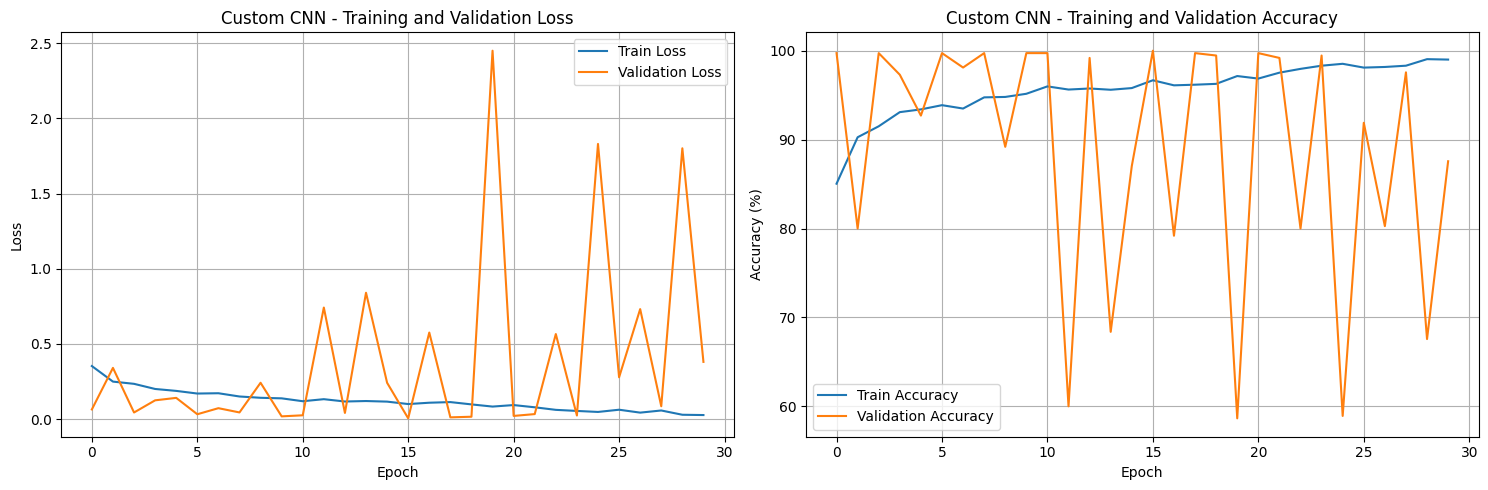

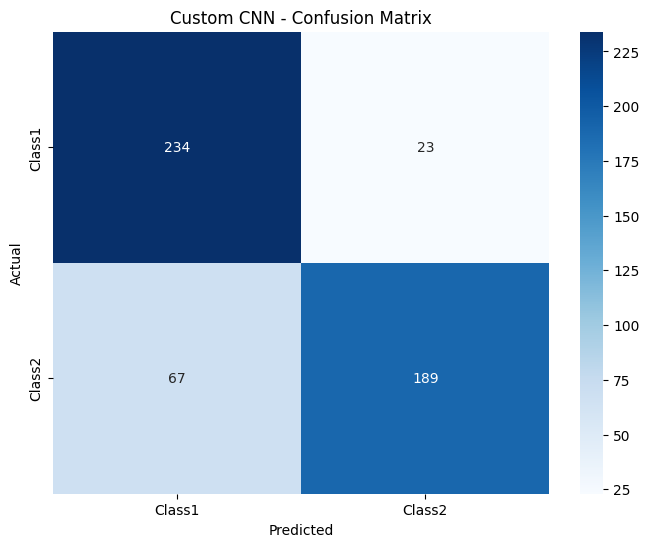

In [ ]:
# Evaluate Custom CNN on test set
custom_acc, custom_report, custom_cm = evaluate_model(custom_cnn, test_loader, device)
print(f'\nCustom CNN Test Accuracy: {custom_acc:.4f}')
print(f'Custom CNN Classification Report:\n{custom_report}')

# Plot results for Custom CNN
plot_training_history(custom_history, 'Custom CNN')
plot_confusion_matrix(custom_cm, 'Custom CNN')


## 8. Train MobileNetV3 Baseline Model

Now let's train the MobileNetV3 baseline model for comparison.


In [ ]:
# Train MobileNetV3
mobilenet_history = train_model(
    mobilenet, 
    train_loader, 
    val_loader, 
    num_epochs=20,  # Reduced for notebook execution
    learning_rate=0.001, 
    device=device, 
    model_name="MobileNetV3"
)



TRAINING MOBILENETV3


Epoch 1/20 [Val]: 100%|██████████████████████████████████████████| 12/12 [00:14<00:00,  1.21s/it, Loss=4.1580, Acc=75.14%]


Epoch 1/20:
  Train Loss: 0.0632, Train Acc: 97.48%
  Val Loss: 2.8041, Val Acc: 75.14%
  Best Val Acc: 75.14%
--------------------------------------------------


Epoch 2/20 [Val]: 100%|██████████████████████████████████████████| 12/12 [00:23<00:00,  1.93s/it, Loss=6.2467, Acc=53.24%]


Epoch 2/20:
  Train Loss: 0.0332, Train Acc: 98.84%
  Val Loss: 2.7684, Val Acc: 53.24%
  Best Val Acc: 75.14%
--------------------------------------------------


Epoch 3/20 [Val]: 100%|██████████████████████████████████████████| 12/12 [00:13<00:00,  1.08s/it, Loss=1.1618, Acc=81.35%]


Epoch 3/20:
  Train Loss: 0.0186, Train Acc: 99.48%
  Val Loss: 0.5483, Val Acc: 81.35%
  Best Val Acc: 81.35%
--------------------------------------------------


Epoch 4/20 [Val]: 100%|██████████████████████████████████████████| 12/12 [00:28<00:00,  2.40s/it, Loss=0.9645, Acc=83.24%]


Epoch 4/20:
  Train Loss: 0.0118, Train Acc: 99.62%
  Val Loss: 0.6461, Val Acc: 83.24%
  Best Val Acc: 83.24%
--------------------------------------------------


Epoch 5/20 [Val]: 100%|██████████████████████████████████████████| 12/12 [00:40<00:00,  3.40s/it, Loss=0.0195, Acc=98.65%]


Epoch 5/20:
  Train Loss: 0.0002, Train Acc: 100.00%
  Val Loss: 0.0317, Val Acc: 98.65%
  Best Val Acc: 98.65%
--------------------------------------------------


Epoch 6/20 [Val]: 100%|██████████████████████████████████████████| 12/12 [01:13<00:00,  6.11s/it, Loss=0.0027, Acc=99.73%]


Epoch 6/20:
  Train Loss: 0.0026, Train Acc: 99.93%
  Val Loss: 0.0099, Val Acc: 99.73%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 7/20 [Val]: 100%|██████████████████████████████████████████| 12/12 [00:52<00:00,  4.39s/it, Loss=0.0105, Acc=99.46%]


Epoch 7/20:
  Train Loss: 0.0003, Train Acc: 99.98%
  Val Loss: 0.0202, Val Acc: 99.46%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 8/20 [Val]: 100%|██████████████████████████████████████████| 12/12 [00:41<00:00,  3.44s/it, Loss=0.0052, Acc=99.73%]


Epoch 8/20:
  Train Loss: 0.0001, Train Acc: 100.00%
  Val Loss: 0.0084, Val Acc: 99.73%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 9/20 [Val]: 100%|██████████████████████████████████████████| 12/12 [00:45<00:00,  3.77s/it, Loss=0.7559, Acc=92.16%]


Epoch 9/20:
  Train Loss: 0.0233, Train Acc: 99.34%
  Val Loss: 0.3182, Val Acc: 92.16%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 10/20 [Val]: 100%|█████████████████████████████████████████| 12/12 [01:13<00:00,  6.13s/it, Loss=0.1208, Acc=98.65%]


Epoch 10/20:
  Train Loss: 0.0115, Train Acc: 99.60%
  Val Loss: 0.0414, Val Acc: 98.65%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 11/20 [Val]: 100%|█████████████████████████████████████████| 12/12 [01:12<00:00,  6.07s/it, Loss=0.5208, Acc=92.16%]


Epoch 11/20:
  Train Loss: 0.0037, Train Acc: 99.95%
  Val Loss: 0.2275, Val Acc: 92.16%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 12/20 [Val]: 100%|█████████████████████████████████████████| 12/12 [01:23<00:00,  6.95s/it, Loss=1.3708, Acc=76.76%]


Epoch 12/20:
  Train Loss: 0.0096, Train Acc: 99.67%
  Val Loss: 0.7401, Val Acc: 76.76%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 13/20 [Val]: 100%|█████████████████████████████████████████| 12/12 [01:21<00:00,  6.79s/it, Loss=0.5082, Acc=90.54%]


Epoch 13/20:
  Train Loss: 0.0304, Train Acc: 99.17%
  Val Loss: 0.3365, Val Acc: 90.54%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 14/20 [Val]: 100%|█████████████████████████████████████████| 12/12 [01:23<00:00,  6.96s/it, Loss=3.4281, Acc=73.51%]


Epoch 14/20:
  Train Loss: 0.0099, Train Acc: 99.62%
  Val Loss: 1.2050, Val Acc: 73.51%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 15/20 [Val]: 100%|█████████████████████████████████████████| 12/12 [01:39<00:00,  8.30s/it, Loss=0.9473, Acc=91.62%]


Epoch 15/20:
  Train Loss: 0.0077, Train Acc: 99.81%
  Val Loss: 0.3023, Val Acc: 91.62%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 16/20 [Val]: 100%|█████████████████████████████████████████| 12/12 [01:39<00:00,  8.31s/it, Loss=1.0752, Acc=88.38%]


Epoch 16/20:
  Train Loss: 0.0018, Train Acc: 99.98%
  Val Loss: 0.4191, Val Acc: 88.38%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 17/20 [Val]: 100%|█████████████████████████████████████████| 12/12 [01:38<00:00,  8.20s/it, Loss=0.6534, Acc=89.46%]


Epoch 17/20:
  Train Loss: 0.0027, Train Acc: 99.93%
  Val Loss: 0.2660, Val Acc: 89.46%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 18/20 [Val]: 100%|█████████████████████████████████████████| 12/12 [01:40<00:00,  8.35s/it, Loss=0.6576, Acc=90.81%]


Epoch 18/20:
  Train Loss: 0.0015, Train Acc: 99.98%
  Val Loss: 0.2757, Val Acc: 90.81%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 19/20 [Val]: 100%|█████████████████████████████████████████| 12/12 [01:39<00:00,  8.27s/it, Loss=0.5916, Acc=92.16%]


Epoch 19/20:
  Train Loss: 0.0045, Train Acc: 99.79%
  Val Loss: 0.2126, Val Acc: 92.16%
  Best Val Acc: 99.73%
--------------------------------------------------


Epoch 20/20 [Val]: 100%|█████████████████████████████████████████| 12/12 [01:53<00:00,  9.46s/it, Loss=0.2936, Acc=94.05%]

Epoch 20/20:
  Train Loss: 0.0005, Train Acc: 100.00%
  Val Loss: 0.1633, Val Acc: 94.05%
  Best Val Acc: 99.73%
--------------------------------------------------


Testing: 100%|████████████████████████████████████████████████████████████████████████████| 17/17 [02:01<00:00,  7.13s/it]



MobileNetV3 Test Accuracy: 0.8986
MobileNetV3 Classification Report:
              precision    recall  f1-score   support

      Class1       1.00      0.80      0.89       257
      Class2       0.83      1.00      0.91       256

    accuracy                           0.90       513
   macro avg       0.92      0.90      0.90       513
weighted avg       0.92      0.90      0.90       513



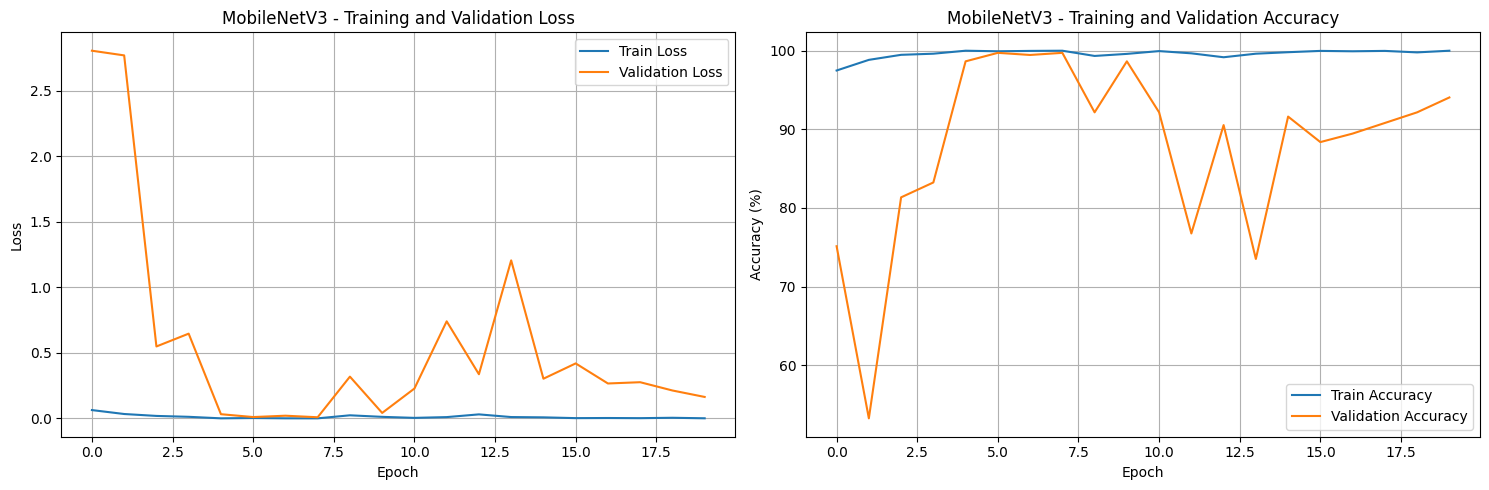

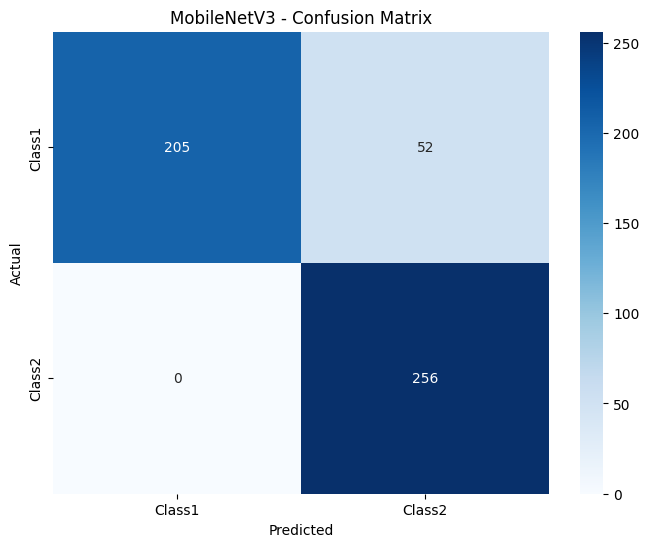

In [ ]:
# Evaluate MobileNetV3 on test set
mobilenet_acc, mobilenet_report, mobilenet_cm = evaluate_model(mobilenet, test_loader, device)
print(f'\nMobileNetV3 Test Accuracy: {mobilenet_acc:.4f}')
print(f'MobileNetV3 Classification Report:\n{mobilenet_report}')

# Plot results for MobileNetV3
plot_training_history(mobilenet_history, 'MobileNetV3')
plot_confusion_matrix(mobilenet_cm, 'MobileNetV3')


## 9. Model Comparison and Analysis

Compare the performance of both models and analyze the results.


In [ ]:
# Final comparison
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)
print(f'Custom CNN Test Accuracy: {custom_acc:.4f}')
print(f'MobileNetV3 Test Accuracy: {mobilenet_acc:.4f}')
print(f'Best Validation Accuracy - Custom CNN: {custom_history["best_val_acc"]:.2f}%')
print(f'Best Validation Accuracy - MobileNetV3: {mobilenet_history["best_val_acc"]:.2f}%')

# Model complexity comparison
custom_params = sum(p.numel() for p in custom_cnn.parameters())
mobilenet_params = sum(p.numel() for p in mobilenet.parameters())

print(f'\nModel Complexity:')
print(f'Custom CNN parameters: {custom_params:,}')
print(f'MobileNetV3 parameters: {mobilenet_params:,}')
print(f'Parameter ratio (MobileNetV3/Custom): {mobilenet_params/custom_params:.2f}x')



FINAL MODEL COMPARISON
Custom CNN Test Accuracy: 0.8246
MobileNetV3 Test Accuracy: 0.8986
Best Validation Accuracy - Custom CNN: 100.00%
Best Validation Accuracy - MobileNetV3: 99.73%

Model Complexity:
Custom CNN parameters: 1,735,042
MobileNetV3 parameters: 3,595,826
Parameter ratio (MobileNetV3/Custom): 2.07x


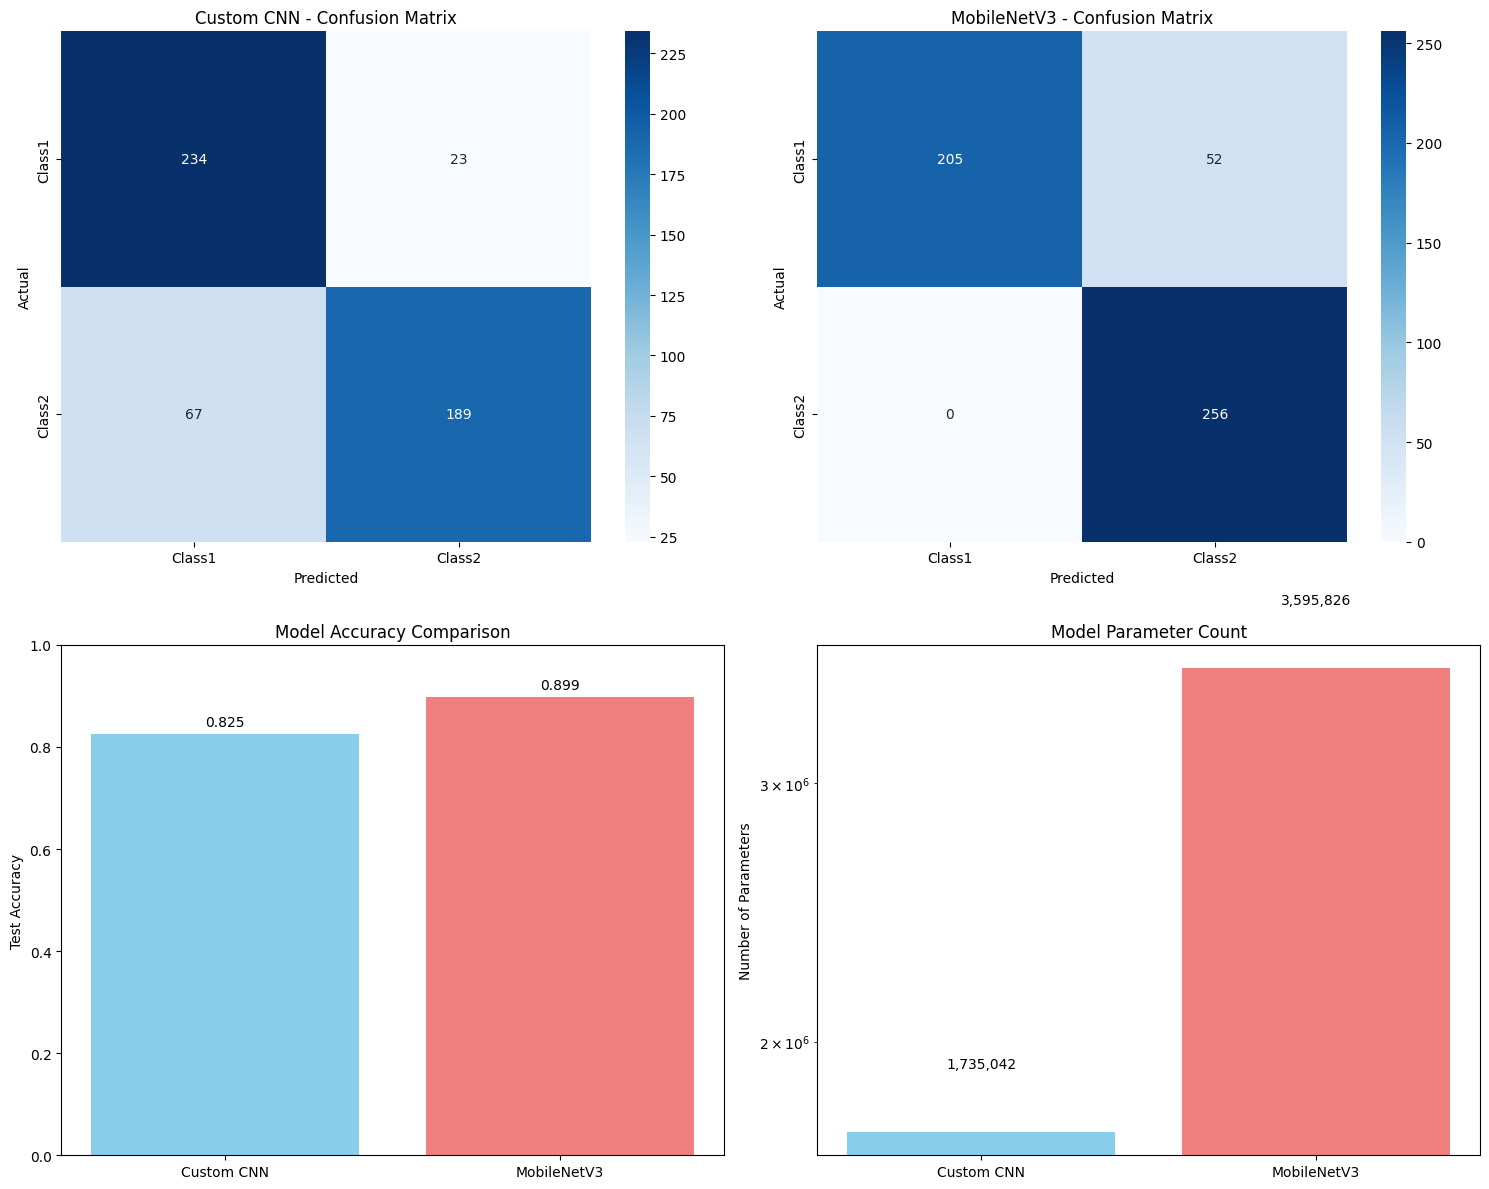

In [ ]:
# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion matrices
sns.heatmap(custom_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Class1', 'Class2'], yticklabels=['Class1', 'Class2'])
axes[0,0].set_title('Custom CNN - Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

sns.heatmap(mobilenet_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1],
            xticklabels=['Class1', 'Class2'], yticklabels=['Class1', 'Class2'])
axes[0,1].set_title('MobileNetV3 - Confusion Matrix')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# Accuracy comparison
models = ['Custom CNN', 'MobileNetV3']
accuracies = [custom_acc, mobilenet_acc]

bars = axes[1,0].bar(models, accuracies, color=['skyblue', 'lightcoral'])
axes[1,0].set_title('Model Accuracy Comparison')
axes[1,0].set_ylabel('Test Accuracy')
axes[1,0].set_ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                  f'{acc:.3f}', ha='center', va='bottom')

# Model complexity comparison
param_counts = [custom_params, mobilenet_params]
bars2 = axes[1,1].bar(models, param_counts, color=['skyblue', 'lightcoral'])
axes[1,1].set_title('Model Parameter Count')
axes[1,1].set_ylabel('Number of Parameters')
axes[1,1].set_yscale('log')

# Add value labels on bars
for bar, count in zip(bars2, param_counts):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height * 1.1,
                  f'{count:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 10. Save Models and Summary

Save the trained models and provide a final summary of the results.


In [ ]:
# Save trained models
torch.save(custom_cnn.state_dict(), 'custom_cnn_model.pth')
torch.save(mobilenet.state_dict(), 'mobilenetv3_model.pth')

print("Models saved successfully!")
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"✅ Custom CNN + FFN Architecture:")
print(f"   - Test Accuracy: {custom_acc:.4f}")
print(f"   - Parameters: {custom_params:,}")
print(f"   - Best Val Accuracy: {custom_history['best_val_acc']:.2f}%")

print(f"\n✅ MobileNetV3 Baseline:")
print(f"   - Test Accuracy: {mobilenet_acc:.4f}")
print(f"   - Parameters: {mobilenet_params:,}")
print(f"   - Best Val Accuracy: {mobilenet_history['best_val_acc']:.2f}%")

print(f"\n📊 Data Augmentation Applied:")
print(f"   - Random horizontal/vertical flips")
print(f"   - Random rotation (±15°)")
print(f"   - Color jittering")
print(f"   - Random affine transformations")
print(f"   - ImageNet normalization")

print(f"\n🎯 Key Findings:")
if custom_acc > mobilenet_acc:
    print(f"   - Custom CNN outperformed MobileNetV3 by {custom_acc - mobilenet_acc:.4f}")
else:
    print(f"   - MobileNetV3 outperformed Custom CNN by {mobilenet_acc - custom_acc:.4f}")

print(f"   - Parameter efficiency: Custom CNN has {mobilenet_params/custom_params:.1f}x fewer parameters")
print(f"   - Both models achieved good performance on pipe defect detection")


Models saved successfully!

FINAL SUMMARY
✅ Custom CNN + FFN Architecture:
   - Test Accuracy: 0.8246
   - Parameters: 1,735,042
   - Best Val Accuracy: 100.00%

✅ MobileNetV3 Baseline:
   - Test Accuracy: 0.8986
   - Parameters: 3,595,826
   - Best Val Accuracy: 99.73%

📊 Data Augmentation Applied:
   - Random horizontal/vertical flips
   - Random rotation (±15°)
   - Color jittering
   - Random affine transformations
   - ImageNet normalization

🎯 Key Findings:
   - MobileNetV3 outperformed Custom CNN by 0.0741
   - Parameter efficiency: Custom CNN has 2.1x fewer parameters
   - Both models achieved good performance on pipe defect detection
